In [9]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import shutil
import os
import sys

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')

# plt.rc('font', family='Arial', size=12)
# plt.rc('axes', titlesize=16, labelsize=14, grid=True)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=18, frameon=False)
plt.rc('xtick', labelsize=14, direction='in')
plt.rc('ytick', labelsize=14, direction='in')
plt.rc('figure', figsize=(6, 4), dpi=100)

In [10]:
os.chdir('/home/zongchen/nest_bq/results_server/bo/dropwave/')
dirs = []
for d in os.listdir('.'):
    dirs.append(d)

print(dirs)

# Arrays to store the I_nkq and I_nmc values
iter_num = 100
seed_num = len(dirs) / 3
I_nkq_values_array_dropwave = None
I_nmc_values_array_dropwave = None
I_mlmc_values_array_dropwave = None

dim = 2
kernel = 'matern'
N = 56

# Loop over seed numbers and load data
for d in dirs:
    if 'EI_look_ahead_kq' in d and f'kernel_{kernel}' in d and f'dim_{dim}' in d and f'N_{N}' in d:
        if I_nkq_values_array_dropwave is None:
            I_nkq_values_array_dropwave = np.load(f"{d}/bo_nmse.npy", 'r') 
        else:
            I_nkq_values_array_dropwave = np.vstack((I_nkq_values_array_dropwave, np.load(f"{d}/bo_nmse.npy", 'r')))

    if 'EI_look_ahead_mc' in d and f'dim_{dim}' in d and f'N_{N}' in d:
        if I_nmc_values_array_dropwave is None:
            I_nmc_values_array_dropwave = np.load(f"{d}/bo_nmse.npy", 'r')
        else:
            I_nmc_values_array_dropwave = np.vstack((I_nmc_values_array_dropwave, np.load(f"{d}/bo_nmse.npy", 'r')))

    if 'EI_look_ahead_mlmc' in d and f'dim_{dim}' in d and f'N_{N}' in d:
        if I_mlmc_values_array_dropwave is None:
            try:
                I_mlmc_values_array_dropwave = np.load(f"{d}/bo_nmse.npy", 'r') 
            except:
                pass
        else:
            try:
                I_mlmc_values_array_dropwave = np.vstack((I_mlmc_values_array_dropwave, np.load(f"{d}/bo_nmse.npy", 'r')))
            except:
                pass

# Compute the median and standard deviation
I_nkq_median_dropwave = np.median(I_nkq_values_array_dropwave, axis=0)
I_nkq_q25_dropwave = np.percentile(I_nkq_values_array_dropwave, 25, axis=0)
I_nkq_q75_dropwave = np.percentile(I_nkq_values_array_dropwave, 75, axis=0)

I_nmc_median_dropwave = np.median(I_nmc_values_array_dropwave, axis=0)
I_nmc_q25_dropwave = np.percentile(I_nmc_values_array_dropwave, 25, axis=0)
I_nmc_q75_dropwave = np.percentile(I_nmc_values_array_dropwave, 75, axis=0)

I_mlmc_median_dropwave = np.median(I_mlmc_values_array_dropwave, axis=0)
I_mlmc_q25_dropwave = np.percentile(I_mlmc_values_array_dropwave, 25, axis=0)
I_mlmc_q75_dropwave = np.percentile(I_mlmc_values_array_dropwave, 75, axis=0)


['EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_17__complete', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_12__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_18__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_8__complete', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_18__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_12__complete', 'EI_look_ahead_mlmc__dim_2__N_56__kernel_matern__seed_19__complete', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_15__complete', 'EI_look_ahead_kq__dim_2__N_56__kernel_matern__seed_13__complete', 'EI_look_ahead_mlmc__dim_2__N_28__kernel_matern__seed_20__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_20__complete', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_10__complete', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_20__complete', 'EI_look_ahead_kq__dim_2__N_56__kernel_matern__seed_10__complete', 'EI_look_ahead_mlmc__dim_2__N_56__kernel_matern__seed_7__c

In [11]:
os.chdir('/home/zongchen/nest_bq/results_server/bo/branin/')
dirs = []
for d in os.listdir('.'):
    dirs.append(d)

print(dirs)

# Arrays to store the I_nkq and I_nmc values
iter_num = 100
seed_num = len(dirs) / 3
I_nkq_values_array_branin = None
I_nmc_values_array_branin = None
I_mlmc_values_array_branin = None

dim = 2
kernel = 'matern'

# Loop over seed numbers and load data
for d in dirs:
    if 'EI_look_ahead_kq' in d and f'kernel_{kernel}' in d and f'dim_{dim}' in d and f'N_{N}' in d:
        if I_nkq_values_array_branin is None:
            I_nkq_values_array_branin = np.load(f"{d}/bo_nmse.npy", 'r') 
        else:
            I_nkq_values_array_branin = np.vstack((I_nkq_values_array_branin, np.load(f"{d}/bo_nmse.npy", 'r')))

    if 'EI_look_ahead_mc' in d and f'dim_{dim}' in d and f'N_{N}' in d:
        if I_nmc_values_array_branin is None:
            I_nmc_values_array_branin = np.load(f"{d}/bo_nmse.npy", 'r')
        else:
            I_nmc_values_array_branin = np.vstack((I_nmc_values_array_branin, np.load(f"{d}/bo_nmse.npy", 'r')))

    if 'EI_look_ahead_mlmc' in d and f'dim_{dim}' in d and f'N_{N}' in d:
        if I_mlmc_values_array_branin is None:
            try:
                I_mlmc_values_array_branin = np.load(f"{d}/bo_nmse.npy", 'r') 
            except:
                pass
        else:
            try:
                I_mlmc_values_array_branin = np.vstack((I_mlmc_values_array_branin, np.load(f"{d}/bo_nmse.npy", 'r')))
            except:
                pass

# Compute the median and standard deviation
I_nkq_median_branin = np.median(I_nkq_values_array_branin, axis=0)
I_nkq_q25_branin = np.percentile(I_nkq_values_array_branin, 25, axis=0)
I_nkq_q75_branin = np.percentile(I_nkq_values_array_branin, 75, axis=0)

I_nmc_median_branin = np.median(I_nmc_values_array_branin, axis=0)
I_nmc_q25_branin = np.percentile(I_nmc_values_array_branin, 25, axis=0)
I_nmc_q75_branin = np.percentile(I_nmc_values_array_branin, 75, axis=0)

I_mlmc_median_branin = np.median(I_mlmc_values_array_branin, axis=0)
I_mlmc_q25_branin = np.percentile(I_mlmc_values_array_branin, 25, axis=0)
I_mlmc_q75_branin = np.percentile(I_mlmc_values_array_branin, 75, axis=0)


['EI_look_ahead_mlmc__dim_2__N_56__kernel_matern__seed_10', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_17__complete', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_12__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_18__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_8__complete', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_18__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_12__complete', 'EI_look_ahead_mlmc__dim_2__N_56__kernel_matern__seed_19__complete', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_15__complete', 'EI_look_ahead_kq__dim_2__N_56__kernel_matern__seed_13__complete', 'EI_look_ahead_mlmc__dim_2__N_28__kernel_matern__seed_20__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_20__complete', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_10__complete', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_20__complete', 'EI_look_ahead_kq__dim_2__N_56__kernel_matern__seed_10__complete',

In [12]:
dataset_all = ['dropwave', 'branin', 'ackley', 'cosine8']


os.chdir('/home/zongchen/nest_bq/results_server/bo/ackley/')
dirs = []
for d in os.listdir('.'):
    dirs.append(d)

print(dirs)

# Arrays to store the I_nkq and I_nmc values
iter_num = 100
seed_num = len(dirs) / 3
I_nkq_values_array_ackley = None
I_nmc_values_array_ackley = None
I_mlmc_values_array_ackley = None

dim = 2
kernel = 'matern'

# Loop over seed numbers and load data
for d in dirs:
    if 'EI_look_ahead_kq' in d and f'kernel_{kernel}' in d and f'dim_{dim}' in d and f'N_{N}' in d:
        if I_nkq_values_array_ackley is None:
            I_nkq_values_array_ackley = np.load(f"{d}/bo_nmse.npy", 'r') 
        else:
            I_nkq_values_array_ackley = np.vstack((I_nkq_values_array_ackley, np.load(f"{d}/bo_nmse.npy", 'r')))

    if 'EI_look_ahead_mc' in d and f'dim_{dim}' in d and f'N_{N}' in d:
        if I_nmc_values_array_ackley is None:
            I_nmc_values_array_ackley = np.load(f"{d}/bo_nmse.npy", 'r')
        else:
            I_nmc_values_array_ackley = np.vstack((I_nmc_values_array_ackley, np.load(f"{d}/bo_nmse.npy", 'r')))

    if 'EI_look_ahead_mlmc' in d and f'dim_{dim}' in d and f'N_{N}' in d:
        if I_mlmc_values_array_ackley is None:
            try:
                I_mlmc_values_array_ackley = np.load(f"{d}/bo_nmse.npy", 'r') 
            except:
                pass
        else:
            try:
                I_mlmc_values_array_ackley = np.vstack((I_mlmc_values_array_ackley, np.load(f"{d}/bo_nmse.npy", 'r')))
            except:
                pass

# Compute the median and standard deviation
I_nkq_median_ackley = np.median(I_nkq_values_array_ackley, axis=0)
I_nkq_q25_ackley = np.percentile(I_nkq_values_array_ackley, 25, axis=0)
I_nkq_q75_ackley = np.percentile(I_nkq_values_array_ackley, 75, axis=0)

I_nmc_median_ackley = np.median(I_nmc_values_array_ackley, axis=0)
I_nmc_q25_ackley = np.percentile(I_nmc_values_array_ackley, 25, axis=0)
I_nmc_q75_ackley = np.percentile(I_nmc_values_array_ackley, 75, axis=0)

I_mlmc_median_ackley = np.median(I_mlmc_values_array_ackley, axis=0)
I_mlmc_q25_ackley = np.percentile(I_mlmc_values_array_ackley, 25, axis=0)
I_mlmc_q75_ackley = np.percentile(I_mlmc_values_array_ackley, 75, axis=0)


['EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_17__complete', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_12__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_18__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_8__complete', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_18__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_12__complete', 'EI_look_ahead_mlmc__dim_2__N_56__kernel_matern__seed_19__complete', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_15__complete', 'EI_look_ahead_kq__dim_2__N_56__kernel_matern__seed_13__complete', 'EI_look_ahead_mlmc__dim_2__N_28__kernel_matern__seed_20__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_20__complete', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_10__complete', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_20__complete', 'EI_look_ahead_kq__dim_2__N_56__kernel_matern__seed_10__complete', 'EI_look_ahead_mlmc__dim_2__N_56__kernel_matern__seed_7__c

In [13]:
os.chdir('/home/zongchen/nest_bq/results_server/bo/cosine8/')
dirs = []
for d in os.listdir('.'):
    dirs.append(d)

print(dirs)

# Arrays to store the I_nkq and I_nmc values
iter_num = 100
seed_num = len(dirs) / 3
I_nkq_values_array_cosine = None
I_nmc_values_array_cosine = None
I_mlmc_values_array_cosine = None

dim = 2
kernel = 'matern'

# Loop over seed numbers and load data
for d in dirs:
    if 'EI_look_ahead_kq' in d and f'kernel_{kernel}' in d and f'dim_{dim}' in d and f'N_{N}' in d:
        if I_nkq_values_array_cosine is None:
            I_nkq_values_array_cosine = np.load(f"{d}/bo_nmse.npy", 'r') 
        else:
            I_nkq_values_array_cosine = np.vstack((I_nkq_values_array_cosine, np.load(f"{d}/bo_nmse.npy", 'r')))

    if 'EI_look_ahead_mc' in d and f'dim_{dim}' in d and f'N_{N}' in d:
        if I_nmc_values_array_cosine is None:
            I_nmc_values_array_cosine = np.load(f"{d}/bo_nmse.npy", 'r')
        else:
            I_nmc_values_array_cosine = np.vstack((I_nmc_values_array_cosine, np.load(f"{d}/bo_nmse.npy", 'r')))

    if 'EI_look_ahead_mlmc' in d and f'dim_{dim}' in d and f'N_{N}' in d:
        if I_mlmc_values_array_cosine is None:
            try:
                I_mlmc_values_array_cosine = np.load(f"{d}/bo_nmse.npy", 'r') 
            except:
                pass
        else:
            try:
                I_mlmc_values_array_cosine = np.vstack((I_mlmc_values_array_cosine, np.load(f"{d}/bo_nmse.npy", 'r')))
            except:
                pass

# Compute the median and standard deviation
I_nkq_median_cosine = np.median(I_nkq_values_array_cosine, axis=0)
I_nkq_q25_cosine = np.percentile(I_nkq_values_array_cosine, 25, axis=0)
I_nkq_q75_cosine = np.percentile(I_nkq_values_array_cosine, 75, axis=0)

I_nmc_median_cosine = np.median(I_nmc_values_array_cosine, axis=0)
I_nmc_q25_cosine = np.percentile(I_nmc_values_array_cosine, 25, axis=0)
I_nmc_q75_cosine = np.percentile(I_nmc_values_array_cosine, 75, axis=0)

I_mlmc_median_cosine = np.median(I_mlmc_values_array_cosine, axis=0)
I_mlmc_q25_cosine = np.percentile(I_mlmc_values_array_cosine, 25, axis=0)
I_mlmc_q75_cosine = np.percentile(I_mlmc_values_array_cosine, 75, axis=0)


['EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_17__complete', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_12__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_18__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_8__complete', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_18__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_12__complete', 'EI_look_ahead_mlmc__dim_2__N_56__kernel_matern__seed_19__complete', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_15__complete', 'EI_look_ahead_kq__dim_2__N_56__kernel_matern__seed_13__complete', 'EI_look_ahead_mlmc__dim_2__N_28__kernel_matern__seed_20__complete', 'EI_look_ahead_mc__dim_2__N_56__kernel_matern__seed_20__complete', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_10__complete', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_20__complete', 'EI_look_ahead_kq__dim_2__N_56__kernel_matern__seed_10__complete', 'EI_look_ahead_mlmc__dim_2__N_56__kernel_matern__seed_7__c

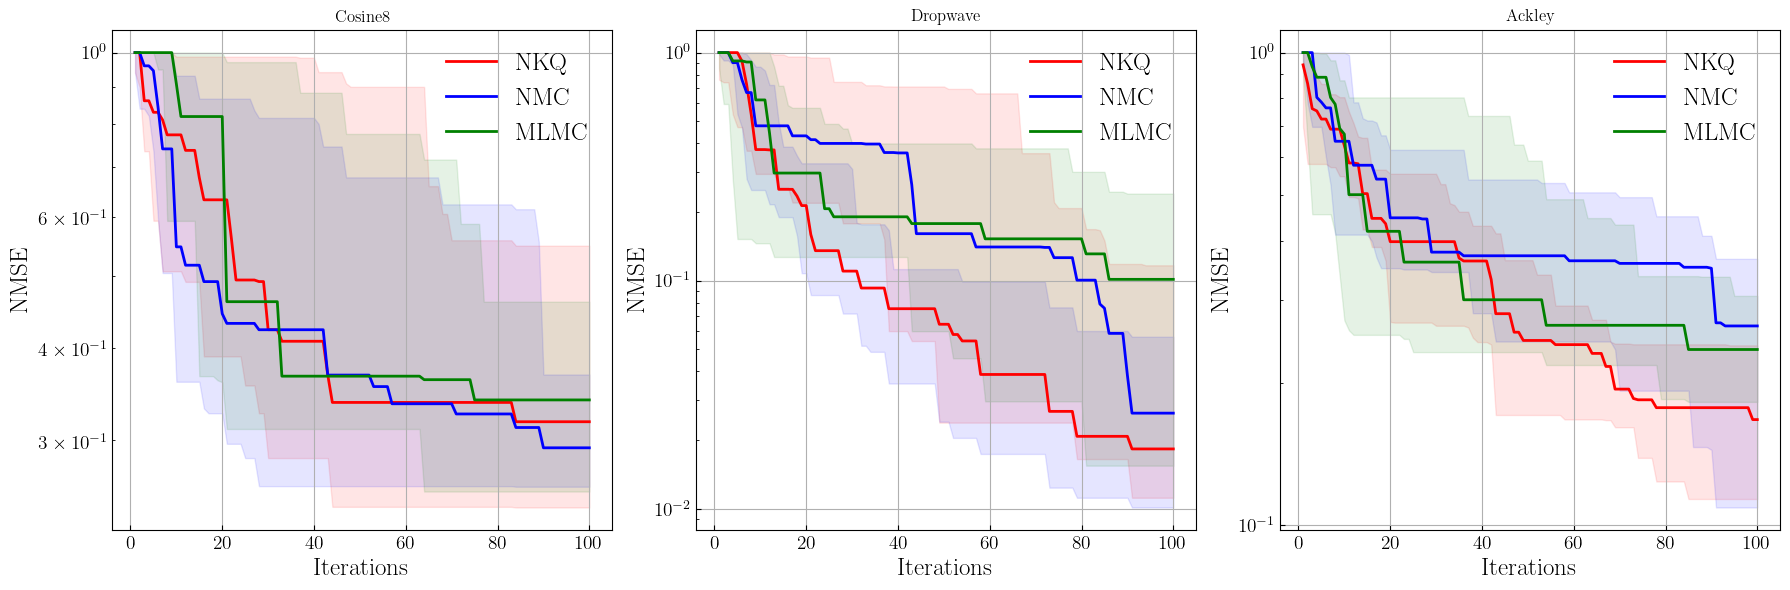

In [17]:
iter_array = np.arange(1, iter_num + 1)

# Create a figure with 3 subplots, arranged vertically
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 3 rows, 1 column of subplots

 
# First plot for I_nkq_median_branin
# axs[0].plot(iter_array, I_nkq_median_branin, label='NKQ', color='red')
# axs[0].fill_between(iter_array, I_nkq_q25_branin, I_nkq_q75_branin, alpha=0.1, color='red')
# axs[0].plot(iter_array, I_nmc_median_branin, label='NMC', color='blue')
# axs[0].fill_between(iter_array, I_nmc_q25_branin, I_nmc_q75_branin, alpha=0.1, color='blue')
# axs[0].plot(iter_array, I_mlmc_median_branin, label='MLMC', color='green')
# axs[0].fill_between(iter_array, I_mlmc_q25_branin, I_mlmc_q75_branin, alpha=0.1, color='green')
# axs[0].set_xlabel('Iterations')
# axs[0].set_ylabel('NMSE')
# axs[0].set_yscale('log')
# axs[0].legend()
# axs[0].set_title('Branin')

axs[0].plot(iter_array, I_nkq_median_cosine, label='NKQ', color='red')
axs[0].fill_between(iter_array, I_nkq_q25_cosine, I_nkq_q75_cosine, alpha=0.1, color='red')
axs[0].plot(iter_array, I_nmc_median_cosine, label='NMC', color='blue')
axs[0].fill_between(iter_array, I_nmc_q25_cosine, I_nmc_q75_cosine, alpha=0.1, color='blue')
axs[0].plot(iter_array, I_mlmc_median_cosine, label='MLMC', color='green')
axs[0].fill_between(iter_array, I_mlmc_q25_cosine, I_mlmc_q75_cosine, alpha=0.1, color='green')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('NMSE')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_title('Cosine8')

# Second plot for I_nkq_median_dropwave
axs[1].plot(iter_array, I_nmc_median_dropwave, label='NKQ', color='red')
axs[1].fill_between(iter_array, I_nkq_q25_dropwave, I_nkq_q75_dropwave, alpha=0.1, color='red')
axs[1].plot(iter_array, I_nkq_median_dropwave, label='NMC', color='blue')
axs[1].fill_between(iter_array, I_nmc_q25_dropwave, I_nmc_q75_dropwave, alpha=0.1, color='blue')
axs[1].plot(iter_array, I_mlmc_median_dropwave, label='MLMC', color='green')
axs[1].fill_between(iter_array, I_mlmc_q25_dropwave, I_mlmc_q75_dropwave, alpha=0.1, color='green')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('NMSE')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_title('Dropwave')

# Second plot for I_nkq_median_ackley
axs[2].plot(iter_array, I_nkq_median_ackley, label='NKQ', color='red')
axs[2].fill_between(iter_array, I_nkq_q25_ackley, I_nkq_q75_ackley, alpha=0.1, color='red')
axs[2].plot(iter_array, I_nmc_median_ackley, label='NMC', color='blue')
axs[2].fill_between(iter_array, I_nmc_q25_ackley, I_nmc_q75_ackley, alpha=0.1, color='blue')
axs[2].plot(iter_array, I_mlmc_median_ackley, label='MLMC', color='green')
axs[2].fill_between(iter_array, I_mlmc_q25_ackley, I_mlmc_q75_ackley, alpha=0.1, color='green')
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('NMSE')
axs[2].set_yscale('log')
axs[2].legend()
axs[2].set_title('Ackley')
# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()



In [15]:
I_nkq_median_branin

array([1.        , 1.        , 0.92254856, 0.75263313, 0.61736415,
       0.61736415, 0.61736415, 0.56168177, 0.56168177, 0.2793253 ,
       0.17399195, 0.16031574, 0.16031574, 0.12445081, 0.12445081,
       0.12445081, 0.12445081, 0.12445081, 0.10591227, 0.10591227,
       0.0930045 , 0.0930045 , 0.0930045 , 0.0930045 , 0.0930045 ,
       0.0930045 , 0.0930045 , 0.0930045 , 0.0930045 , 0.0930045 ,
       0.0930045 , 0.0930045 , 0.0930045 , 0.0930045 , 0.0930045 ,
       0.0930045 , 0.0930045 , 0.0930045 , 0.0930045 , 0.08468018,
       0.08468018, 0.08468018, 0.08468018, 0.08468018, 0.08468018,
       0.08468018, 0.08468018, 0.08468018, 0.08468018, 0.08468018,
       0.08468018, 0.07137731, 0.07137731, 0.07137731, 0.07137731,
       0.04494753, 0.04494753, 0.04494753, 0.03288851, 0.03288851,
       0.03288851, 0.03288851, 0.03288851, 0.03288851, 0.03288851,
       0.03229279, 0.03229279, 0.03229279, 0.03229279, 0.03229279,
       0.03229279, 0.03229279, 0.02026818, 0.02026818, 0.02026

In [16]:
I_nmc_median_branin

array([1.        , 1.        , 0.92254856, 0.75263313, 0.61736415,
       0.61736415, 0.61736415, 0.56168177, 0.56168177, 0.2793253 ,
       0.17399195, 0.16031574, 0.16031574, 0.12445081, 0.12445081,
       0.12445081, 0.12445081, 0.12445081, 0.10591227, 0.10591227,
       0.0930045 , 0.0930045 , 0.0930045 , 0.0930045 , 0.0930045 ,
       0.0930045 , 0.0930045 , 0.0930045 , 0.0930045 , 0.0930045 ,
       0.0930045 , 0.0930045 , 0.0930045 , 0.0930045 , 0.0930045 ,
       0.0930045 , 0.0930045 , 0.0930045 , 0.0930045 , 0.08468018,
       0.08468018, 0.08468018, 0.08468018, 0.08468018, 0.08468018,
       0.08468018, 0.08468018, 0.08468018, 0.08468018, 0.08468018,
       0.08468018, 0.07137731, 0.07137731, 0.07137731, 0.07137731,
       0.04494753, 0.04494753, 0.04494753, 0.03288851, 0.03288851,
       0.03288851, 0.03288851, 0.03288851, 0.03288851, 0.03288851,
       0.03229279, 0.03229279, 0.03229279, 0.03229279, 0.03229279,
       0.03229279, 0.03229279, 0.02026818, 0.02026818, 0.02026